In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Input, Concatenate
from keras.layers import Conv2D, Conv2DTranspose, Activation, MaxPooling2D, UpSampling2D
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.models import Model
from keras.models import load_model
import tensorflow as tf
from keras import backend as K
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os
from keras import losses

physical_device = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_device[0], True)

In [2]:
images = []
image_shape = (512, 512)
img_path = 'rain/training/'
for i in os.listdir(img_path):
    images.append(cv2.imread(img_path + i))
len(images)

700

In [3]:
co = 0
rain_im = []
derain_im = []
for i in images:
    #print(co)
    co += 1
    col = i.shape[1]
    im = i[:,:col//2,:]
    im2 = i[:,col//2:,:]
    derain_im.append(im)
    rain_im.append(im2)

In [4]:
derain_final = []
for i in derain_im:
    x = cv2.resize(i,(image_shape[1], image_shape[0]))
    x = x/255
    derain_final.append(x)

In [5]:
rain_final = []
for i in rain_im:
    x = cv2.resize(i,(image_shape[1], image_shape[0]))
    x = x/255
    rain_final.append(x)

In [6]:
rain_final = np.asarray(rain_final)
rain_final.shape

(700, 512, 512, 3)

In [7]:
derain_final = np.asarray(derain_final)
derain_final.shape

(700, 512, 512, 3)

In [8]:
input_img = Input(shape=(image_shape[0], image_shape[1], 3))

x = Conv2D(16, (4, 4), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid',padding = 'same')(x)

#decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss=losses.mean_squared_error, metrics = ['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 16)      784       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 128, 128, 32)      18464 

In [9]:
Model.fit(autoencoder, rain_final, derain_final, epochs=150, shuffle=True, batch_size = 30)

Epoch 1/150
35/35 [==============================] - 17s 309ms/step - loss: 0.0656 - accuracy: 0.4225
Epoch 2/150
35/35 [==============================] - 11s 310ms/step - loss: 0.0187 - accuracy: 0.6209
Epoch 3/150
35/35 [==============================] - 11s 310ms/step - loss: 0.0118 - accuracy: 0.6770
Epoch 4/150
35/35 [==============================] - 11s 309ms/step - loss: 0.0136 - accuracy: 0.6973
Epoch 5/150
35/35 [==============================] - 11s 309ms/step - loss: 0.0118 - accuracy: 0.7059
Epoch 6/150
35/35 [==============================] - 11s 309ms/step - loss: 0.0114 - accuracy: 0.7410
Epoch 7/150
35/35 [==============================] - 11s 307ms/step - loss: 0.0102 - accuracy: 0.7793
Epoch 8/150
35/35 [==============================] - 11s 308ms/step - loss: 0.0101 - accuracy: 0.7925
Epoch 9/150
35/35 [==============================] - 11s 307ms/step - loss: 0.0094 - accuracy: 0.8079
Epoch 10/150
35/35 [==============================] - 11s 306ms/step - loss: 0.010

In [10]:
autoencoder.save("model.h5")

In [8]:
auto = load_model("model.h5")

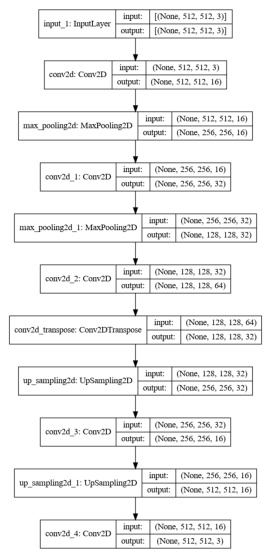

In [15]:
plot_model(auto, to_file='./model.png', show_shapes=True, show_layer_names=True, rankdir='TB')
img = plt.imread('model.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [16]:
a = auto.predict(rain_final[:3])

In [28]:
aa = auto.predict(rain_final[:200])

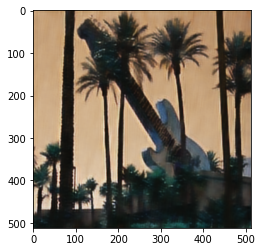

In [21]:
plt.imshow(a[0])

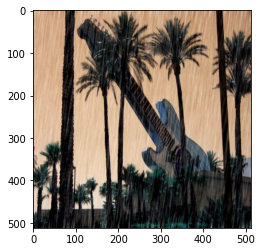

In [22]:
plt.imshow(rain_final[0])

In [23]:
x = rain_final[0]/255
x = x*255

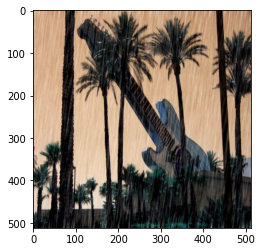

In [24]:
plt.imshow(x)

In [25]:
x = np.rint(x)
x = x.astype(np.uint8)
x

array([[[1, 1, 0],
        [1, 1, 0],
        [1, 1, 1],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[1, 1, 0],
        [1, 1, 0],
        [1, 1, 1],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[1, 1, 0],
        [1, 1, 0],
        [1, 1, 1],
        ...,
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [26]:
rain_final[0]

array([[[0.71372549, 0.52941176, 0.40784314],
        [0.76078431, 0.56862745, 0.44313725],
        [0.83921569, 0.65490196, 0.52941176],
        ...,
        [0.58823529, 0.37254902, 0.21960784],
        [0.63137255, 0.40784314, 0.25490196],
        [0.67843137, 0.45490196, 0.30196078]],

       [[0.71764706, 0.53333333, 0.41176471],
        [0.76470588, 0.57254902, 0.44705882],
        [0.84313725, 0.65882353, 0.53333333],
        ...,
        [0.6       , 0.38039216, 0.23137255],
        [0.64313725, 0.41960784, 0.26666667],
        [0.69019608, 0.46666667, 0.31372549]],

       [[0.7254902 , 0.54117647, 0.41960784],
        [0.77647059, 0.58039216, 0.45490196],
        [0.85490196, 0.66666667, 0.54117647],
        ...,
        [0.61176471, 0.39607843, 0.24705882],
        [0.65882353, 0.43529412, 0.28235294],
        [0.70980392, 0.48627451, 0.33333333]],

       ...,

       [[0.        , 0.03529412, 0.03137255],
        [0.03921569, 0.08627451, 0.08627451],
        [0.09019608, 0

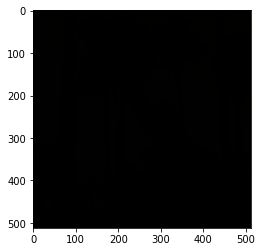

In [27]:
plt.imshow(x)

In [29]:
mse = ((derain_final[:200] - aa) ** 2).mean(axis=None)

mse

In [30]:
mse

0.005525542941757658

In [31]:
psnr = 20*np.log10(1/(mse**(1/2.0)))

In [32]:
psnr

22.57625041620365

In [33]:
x = aa[29]*255

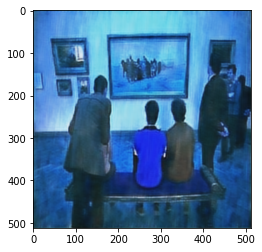

In [34]:
plt.imshow(x.astype(np.uint8))

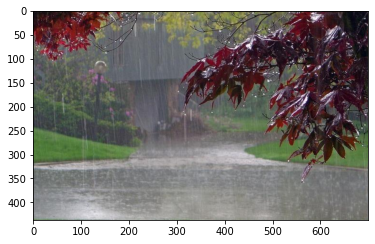

In [72]:
img_test = cv2.imread('rain/test_nature/61.jpg')
# img_test = img_test[:, img_test.shape[1]//5:img_test.shape[1]//5+img_test.shape[0], :]
img_test = img_test[:, :img_test.shape[1]//2, :]
plt.imshow(img_test[:,:,::-1])

In [73]:
img_test.shape

(437, 700, 3)

In [74]:
img_resize = cv2.resize(img_test, image_shape)

In [89]:
derain_test = auto.predict(img_resize.reshape(1, image_shape[0], image_shape[1], 3)/256)

In [90]:
derain_test.shape

(1, 512, 512, 3)

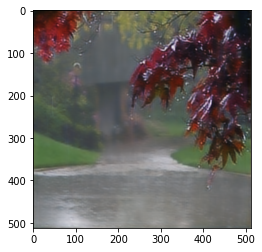

In [91]:
derain_test = derain_test[0]
plt.imshow(derain_test[:,:,::-1])

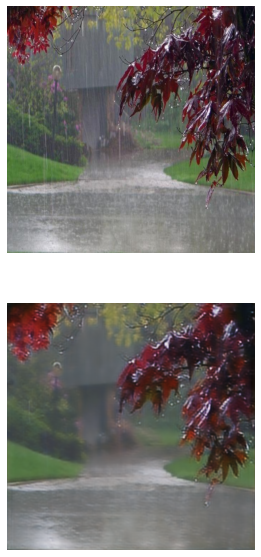

In [94]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(img_resize[:,:,::-1])
plt.axis('off')
plt.subplot(212)
plt.imshow(derain_test[:,:,::-1])
plt.axis('off')
plt.show()